# Oceanic Equatorial Waves - Matsuno Model

This notebook demonstrates oceanic equatorial wave dynamics using the Matsuno shallow water model.

**Oceanic Configuration:**
- Equivalent depth: 1-5 m (first few baroclinic modes)
- Wave speeds: 2-7 m/s 
- Time scales: Weeks to months
- Amplitudes: 0.1-2 m (sea surface height anomalies)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import jax
print("JAX device:", jax.devices())
import jax.numpy as jnp

from matsuno_shallow_water import create_matsuno_model, MatsunoConfig, MatsunoModel

# Enhanced plotting setup for oceanic applications
plt.style.use('default')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 12

# Ocean-specific colormaps
import cmocean.cm as cmo
ocean_cmap = cmo.balance  # Red-blue for ocean anomalies

JAX device: [CpuDevice(id=0)]


## 1. Oceanic Model Configuration

Set up the model with parameters appropriate for oceanic baroclinic modes.

In [4]:
# Create oceanic model - first baroclinic mode
ocean_model = create_matsuno_model(
    equivalent_depth=2.5,   # 2.5 m - typical for oceanic first baroclinic mode
    dt_minutes=15.0,        # 15 minute time step (slower ocean dynamics)
    nt=1440                 # 15 days simulation (360 hours)
)

print("=== OCEANIC EQUATORIAL WAVE MODEL ===")
print(f"Application: ENSO dynamics, tropical Pacific variability")
print(f"Domain: {ocean_model.config.lat_min}°S to {ocean_model.config.lat_max}°N")
print(f"        {ocean_model.config.lon_min}° to {ocean_model.config.lon_max}°E")
print(f"Grid: {ocean_model.config.nlat} × {ocean_model.config.nlon} ({ocean_model.dx/1000:.0f} km resolution)")

print(f"\n=== OCEANIC WAVE PARAMETERS ===")
print(f"Equivalent depth (H):        {ocean_model.config.equivalent_depth} m")
print(f"Kelvin wave speed (c):       {ocean_model.c:.1f} m/s ({ocean_model.c*86.4:.0f} km/day)")
print(f"Deformation radius (L_eq):   {ocean_model.L_eq/1000:.0f} km")
print(f"Beta parameter:              {ocean_model.config.beta:.2e} m⁻¹s⁻¹")

print(f"\n=== OCEANIC TIME SCALES ===")
print(f"Time step:                   {ocean_model.config.dt/60:.0f} minutes")
print(f"Simulation length:           {ocean_model.config.nt * ocean_model.config.dt/86400:.1f} days")
print(f"Kelvin wave transit time:    {120*np.pi/180*ocean_model.config.earth_radius/ocean_model.c/86400:.0f} days (across Pacific)")
print(f"Rossby wave transit time:    ~{120*np.pi/180*ocean_model.config.earth_radius/(ocean_model.c/10)/86400:.0f} days (much slower)")
print(f"CFL numbers: x={ocean_model.cfl_x:.3f}, y={ocean_model.cfl_y:.3f}")

# Check stability
max_cfl = max(ocean_model.cfl_x, ocean_model.cfl_y)
if max_cfl < 0.3:
    print(f"\n✓ Highly stable oceanic configuration (CFL = {max_cfl:.3f})")
elif max_cfl < 0.8:
    print(f"\n✓ Stable oceanic configuration (CFL = {max_cfl:.3f})")
else:
    print(f"\n⚠ Check time step (CFL = {max_cfl:.3f})")

=== OCEANIC EQUATORIAL WAVE MODEL ===
Application: ENSO dynamics, tropical Pacific variability
Domain: -15.0°S to 15.0°N
        0.0° to 120.0°E
Grid: 61 × 241 (56 km resolution)

=== OCEANIC WAVE PARAMETERS ===
Equivalent depth (H):        2.5 m
Kelvin wave speed (c):       5.0 m/s (428 km/day)
Deformation radius (L_eq):   465 km
Beta parameter:              2.29e-11 m⁻¹s⁻¹

=== OCEANIC TIME SCALES ===
Time step:                   15 minutes
Simulation length:           15.0 days
Kelvin wave transit time:    31 days (across Pacific)
Rossby wave transit time:    ~312 days (much slower)
CFL numbers: x=0.080, y=0.080

✓ Highly stable oceanic configuration (CFL = 0.080)


## 2. Oceanic Kelvin Waves 

Oceanic Kelvin waves:
- Thermocline depth variations
- Sea surface temperature anomalies
- Trans-Pacific wave propagation (~2-3 months)

Running oceanic Kelvin wave simulation (El Niño analog)...
✓ Simulation complete: 1441 time steps


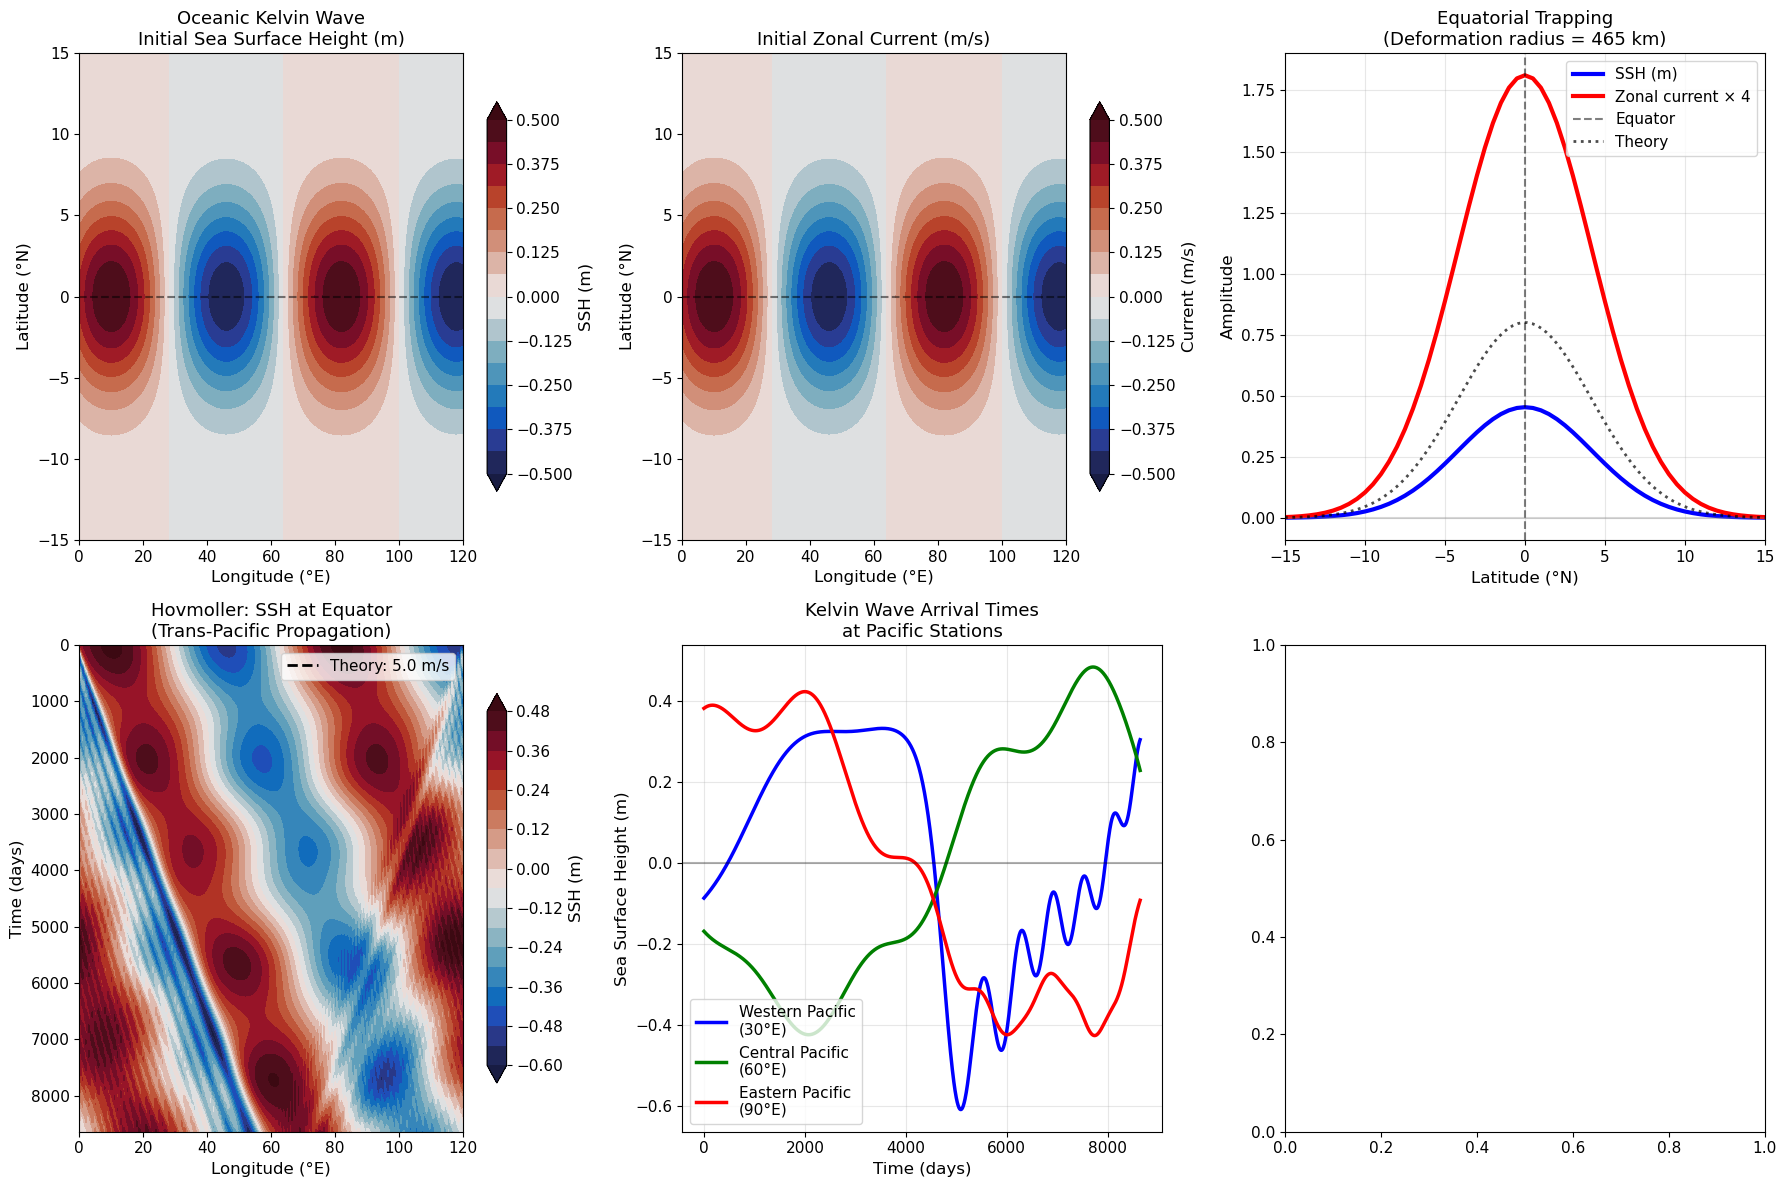

In [10]:
# Initialize oceanic Kelvin wave 
amplitude = 0.5
ocean_kelvin = ocean_model.initialize_kelvin_wave(
    amplitude=amplitude,          # 0.5 m sea surface height anomaly
    wavelength=8000e3,      # 8000 km - basin-scale Kelvin wave
    lon_center=10.0         # Start in west
)

print("Running oceanic Kelvin wave simulation (El Niño analog)...")
ocean_kelvin_states = ocean_model.integrate(ocean_kelvin)
ocean_kelvin_ds = ocean_model.to_xarray(ocean_kelvin_states)
print(f"✓ Simulation complete: {len(ocean_kelvin_ds.time)} time steps")

# Convert time to days for oceanic time scales
time_days = ocean_kelvin_ds.time * 24  # Convert hours to days

# Oceanic Kelvin wave analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Initial conditions - Sea Surface Height
im1 = axes[0,0].contourf(ocean_model.lon, ocean_model.lat, ocean_kelvin[2], 
                        levels=np.linspace(-1*amplitude, amplitude, 17), cmap=ocean_cmap, extend='both')
axes[0,0].set_title('Oceanic Kelvin Wave\nInitial Sea Surface Height (m)')
axes[0,0].set_xlabel('Longitude (°E)')
axes[0,0].set_ylabel('Latitude (°N)')
axes[0,0].axhline(0, color='k', linestyle='--', alpha=0.5, label='Equator')
cbar1 = plt.colorbar(im1, ax=axes[0,0], shrink=0.8)
cbar1.set_label('SSH (m)')

# Initial zonal current
im2 = axes[0,1].contourf(ocean_model.lon, ocean_model.lat, ocean_kelvin[0], 
                        levels=np.linspace(-1*amplitude, amplitude, 17), cmap=ocean_cmap, extend='both')
axes[0,1].set_title('Initial Zonal Current (m/s)')
axes[0,1].set_xlabel('Longitude (°E)')
axes[0,1].set_ylabel('Latitude (°N)')
axes[0,1].axhline(0, color='k', linestyle='--', alpha=0.5)
cbar2 = plt.colorbar(im2, ax=axes[0,1], shrink=0.8)
cbar2.set_label('Current (m/s)')

# Equatorial structure - compare with observations
eq_idx = len(ocean_model.lat) // 2
axes[0,2].plot(ocean_model.lat, ocean_kelvin[2, :, 30], 'b-', linewidth=3, label='SSH (m)')
axes[0,2].plot(ocean_model.lat, ocean_kelvin[0, :, 30]*4, 'r-', linewidth=3, label='Zonal current × 4')
axes[0,2].axvline(0, color='k', linestyle='--', alpha=0.5, label='Equator')
axes[0,2].axhline(0, color='gray', linestyle='-', alpha=0.3)
axes[0,2].set_xlabel('Latitude (°N)')
axes[0,2].set_ylabel('Amplitude')
axes[0,2].set_title('Equatorial Trapping\n(Deformation radius = {:.0f} km)'.format(ocean_model.L_eq/1000))
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)
axes[0,2].set_xlim(-15, 15)

# Add theoretical trapping scale
lat_theory = np.linspace(-15, 15, 100)
y_theory = lat_theory * np.pi/180 * ocean_model.config.earth_radius
trapping_theory = 0.8 * np.exp(-0.5 * (y_theory / ocean_model.L_eq)**2)
axes[0,2].plot(lat_theory, trapping_theory, 'k:', linewidth=2, alpha=0.7, label='Theory')
axes[0,2].legend()

# Hovmoller diagram - Trans-Pacific propagation
eta_eq = ocean_kelvin_ds.eta[:, eq_idx, :]
X, T = np.meshgrid(ocean_kelvin_ds.lon, time_days)
im3 = axes[1,0].contourf(X, T, eta_eq, levels=21, cmap=ocean_cmap, extend='both')
axes[1,0].set_xlabel('Longitude (°E)')
axes[1,0].set_ylabel('Time (days)')
axes[1,0].set_title('Hovmoller: SSH at Equator\n(Trans-Pacific Propagation)')
cbar3 = plt.colorbar(im3, ax=axes[1,0], shrink=0.8)
cbar3.set_label('SSH (m)')

# Add theoretical speed line
speed_deg_per_day = ocean_model.c * 180 / (np.pi * ocean_model.config.earth_radius) * 86400
time_line = np.linspace(0, time_days[-1].values, 100)
lon_theory = 10 + speed_deg_per_day * time_line
valid_idx = (lon_theory >= ocean_model.config.lon_min) & (lon_theory <= ocean_model.config.lon_max)
axes[1,0].plot(lon_theory[valid_idx], time_line[valid_idx], 'k--', linewidth=2, 
              label=f'Theory: {ocean_model.c:.1f} m/s')
axes[1,0].legend(loc='upper right')
axes[1,0].invert_yaxis()

# Time series at key Pacific locations
pacific_locations = [
    (30, 'Western Pacific', 'blue'),
    (60, 'Central Pacific', 'green'), 
    (90, 'Eastern Pacific', 'red')
]

for lon_val, region, color in pacific_locations:
    lon_idx = int((lon_val - ocean_model.config.lon_min) / 
                  (ocean_model.config.lon_max - ocean_model.config.lon_min) * 
                  (ocean_model.config.nlon - 1))
    if 0 <= lon_idx < len(ocean_model.lon):
        eta_series = ocean_kelvin_ds.eta[:, eq_idx, lon_idx]
        axes[1,1].plot(time_days, eta_series, linewidth=2.5, color=color,
                      label=f'{region}\n({lon_val}°E)')

axes[1,1].set_xlabel('Time (days)')
axes[1,1].set_ylabel('Sea Surface Height (m)')
axes[1,1].set_title('Kelvin Wave Arrival Times\nat Pacific Stations')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axhline(0, color='k', linestyle='-', alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Oceanic Rossby Waves

Oceanic Rossby waves:
- Ocean adjustment to wind stress changes
- Thermocline tilt adjustments

Running oceanic Rossby wave simulation...
✓ Simulation complete


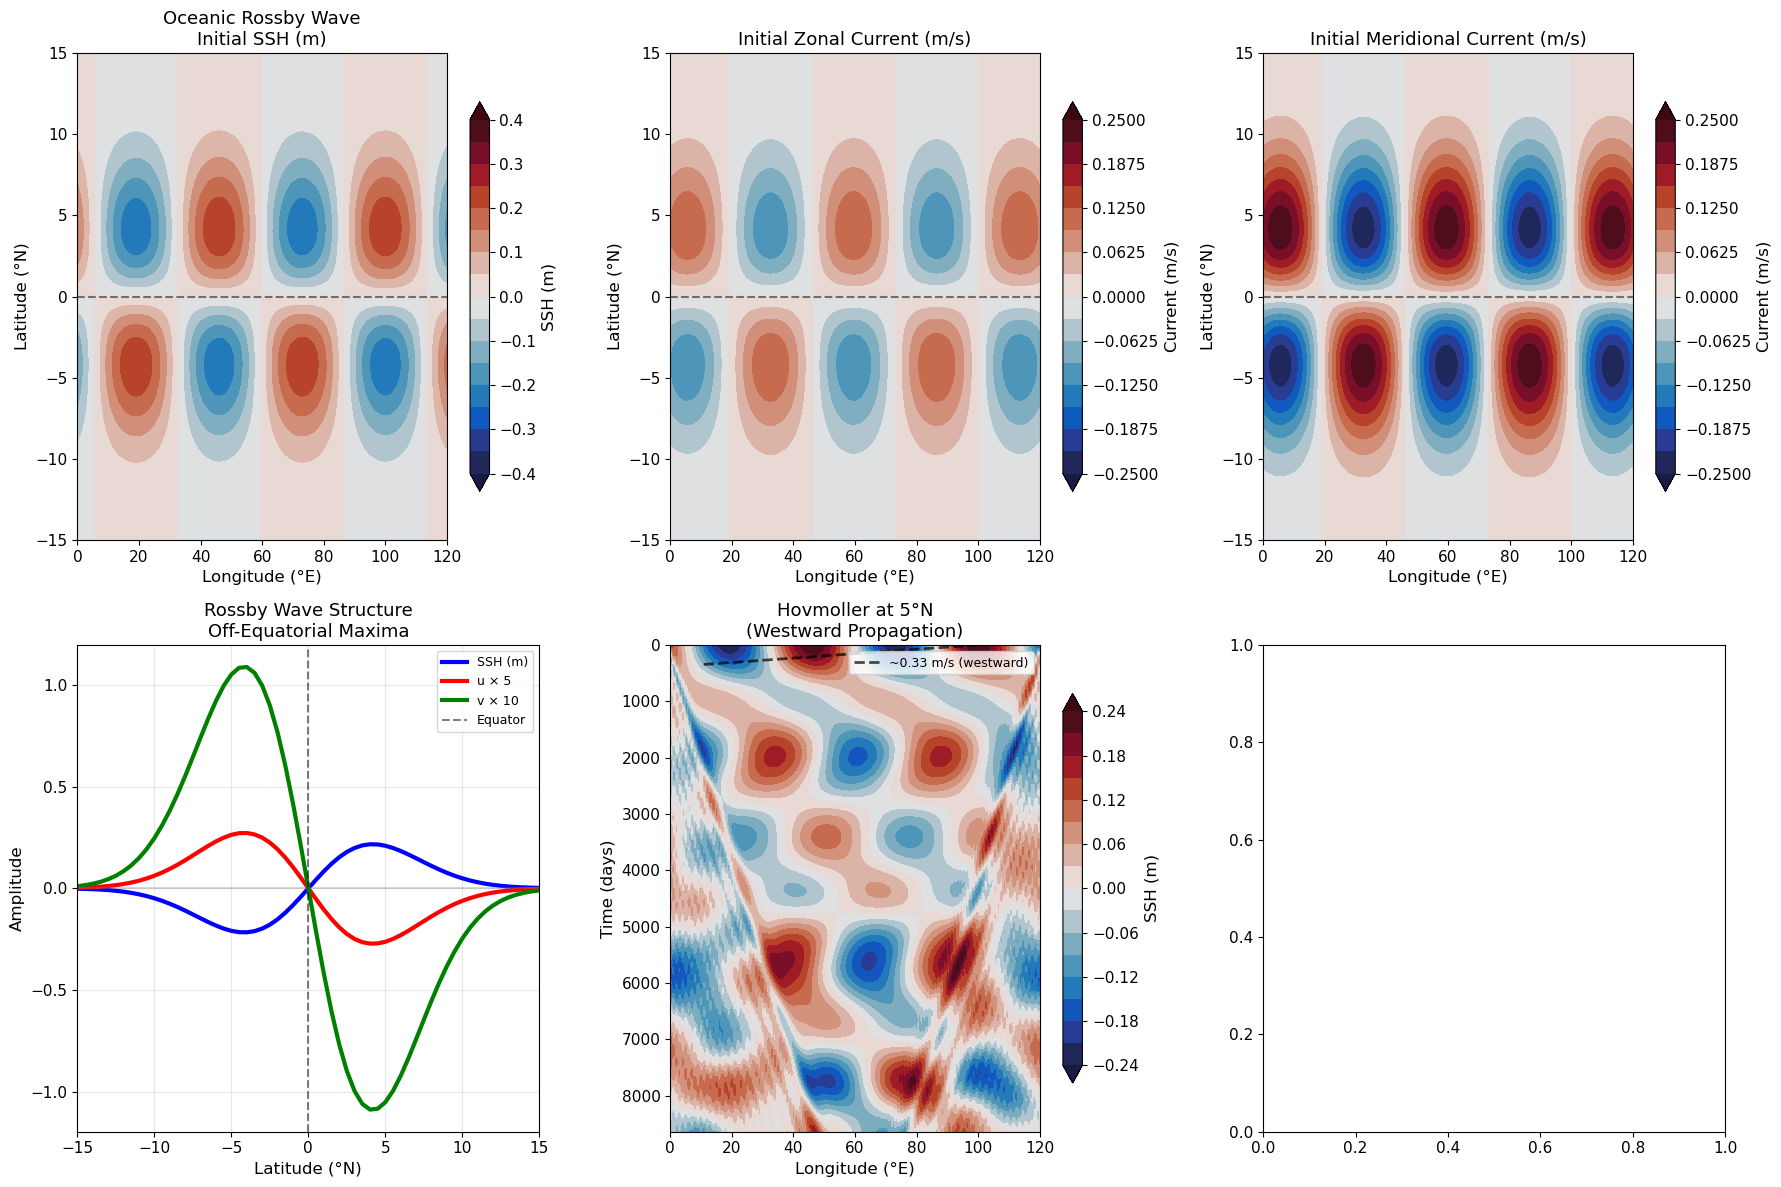

In [15]:
# Initialize oceanic Rossby wave - La Niña/adjustment scenario
ocean_rossby = ocean_model.initialize_rossby_wave(
    amplitude=0.4,          # 0.4 m amplitude (smaller than Kelvin)
    wavelength=6000e3,      # 6000 km - typical for Pacific Rossby waves
    mode=1,                 # First meridional mode
    lon_center=100.0        # Start in eastern Pacific
)

print("Running oceanic Rossby wave simulation...")
ocean_rossby_states = ocean_model.integrate(ocean_rossby)
ocean_rossby_ds = ocean_model.to_xarray(ocean_rossby_states)
print(f"✓ Simulation complete")

# Rossby wave analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Initial SSH structure
im1 = axes[0,0].contourf(ocean_model.lon, ocean_model.lat, ocean_rossby[2], 
                        levels=np.linspace(-0.4, 0.4, 17), cmap=ocean_cmap, extend='both')
axes[0,0].set_title('Oceanic Rossby Wave\nInitial SSH (m)')
axes[0,0].set_xlabel('Longitude (°E)')
axes[0,0].set_ylabel('Latitude (°N)')
axes[0,0].axhline(0, color='k', linestyle='--', alpha=0.5)
cbar1 = plt.colorbar(im1, ax=axes[0,0], shrink=0.8)
cbar1.set_label('SSH (m)')

# Zonal current
im2 = axes[0,1].contourf(ocean_model.lon, ocean_model.lat, ocean_rossby[0], 
                        levels=np.linspace(-0.25, 0.25, 17), cmap=ocean_cmap, extend='both')
axes[0,1].set_title('Initial Zonal Current (m/s)')
axes[0,1].set_xlabel('Longitude (°E)')
axes[0,1].set_ylabel('Latitude (°N)')
axes[0,1].axhline(0, color='k', linestyle='--', alpha=0.5)
cbar2 = plt.colorbar(im2, ax=axes[0,1], shrink=0.8)
cbar2.set_label('Current (m/s)')

# Meridional current  
im3 = axes[0,2].contourf(ocean_model.lon, ocean_model.lat, ocean_rossby[1], 
                        levels=np.linspace(-0.25, 0.25, 17), cmap=ocean_cmap, extend='both')
axes[0,2].set_title('Initial Meridional Current (m/s)')
axes[0,2].set_xlabel('Longitude (°E)')
axes[0,2].set_ylabel('Latitude (°N)')
axes[0,2].axhline(0, color='k', linestyle='--', alpha=0.5)
cbar3 = plt.colorbar(im3, ax=axes[0,2], shrink=0.8)
cbar3.set_label('Current (m/s)')

# Meridional structure showing off-equatorial maxima
lon_idx = int(0.8 * len(ocean_model.lon))  # Eastern Pacific
axes[1,0].plot(ocean_model.lat, ocean_rossby[2, :, lon_idx], 'b-', linewidth=3, label='SSH (m)')
axes[1,0].plot(ocean_model.lat, ocean_rossby[0, :, lon_idx]*5, 'r-', linewidth=3, label='u × 5')
axes[1,0].plot(ocean_model.lat, ocean_rossby[1, :, lon_idx]*10, 'g-', linewidth=3, label='v × 10')
axes[1,0].axvline(0, color='k', linestyle='--', alpha=0.5, label='Equator')
axes[1,0].axhline(0, color='gray', linestyle='-', alpha=0.3)


axes[1,0].set_xlabel('Latitude (°N)')
axes[1,0].set_ylabel('Amplitude')
axes[1,0].set_title('Rossby Wave Structure\nOff-Equatorial Maxima')
axes[1,0].legend(fontsize=9)
axes[1,0].grid(True, alpha=0.3)
axes[1,0].set_xlim(-15, 15)

# Hovmoller diagram at off-equatorial latitude (5°N)
lat_5n_idx = int((5.0 - ocean_model.config.lat_min) / 
                 (ocean_model.config.lat_max - ocean_model.config.lat_min) * 
                 (ocean_model.config.nlat - 1))
eta_5n = ocean_rossby_ds.eta[:, lat_5n_idx, :]
time_days_rossby = ocean_rossby_ds.time * 24
X_r, T_r = np.meshgrid(ocean_rossby_ds.lon, time_days_rossby)
im4 = axes[1,1].contourf(X_r, T_r, eta_5n, levels=17, cmap=ocean_cmap, extend='both')
axes[1,1].set_xlabel('Longitude (°E)')
axes[1,1].set_ylabel('Time (days)')
axes[1,1].set_title('Hovmoller at 5°N\n(Westward Propagation)')
cbar4 = plt.colorbar(im4, ax=axes[1,1], shrink=0.8)
cbar4.set_label('SSH (m)')
axes[1,1].invert_yaxis()

# Add approximate Rossby wave speed (much slower)
rossby_speed_approx = ocean_model.c / 15  # Very rough approximation
speed_deg_per_day_rossby = -rossby_speed_approx * 180 / (np.pi * ocean_model.config.earth_radius) * 86400
time_line_r = np.linspace(0, time_days_rossby[-1].values, 100)
lon_theory_r = 100 + speed_deg_per_day_rossby * time_line_r
valid_idx_r = (lon_theory_r >= ocean_model.config.lon_min) & (lon_theory_r <= ocean_model.config.lon_max)
if np.any(valid_idx_r):
    axes[1,1].plot(lon_theory_r[valid_idx_r], time_line_r[valid_idx_r], 'k--', linewidth=2, 
                  label=f'~{rossby_speed_approx:.2f} m/s (westward)', alpha=0.7)
    axes[1,1].legend(loc='upper right', fontsize=9)


plt.tight_layout()
plt.show()

## 4. Simulation - Wind Stress Response

Simulate an oceanic response to wind stress changes, representing the initiation of an ENSO event.
This shows how a localized forcing can generate both Kelvin and Rossby wave responses.

Running ENSO wind stress response simulation...
✓ Simulation complete


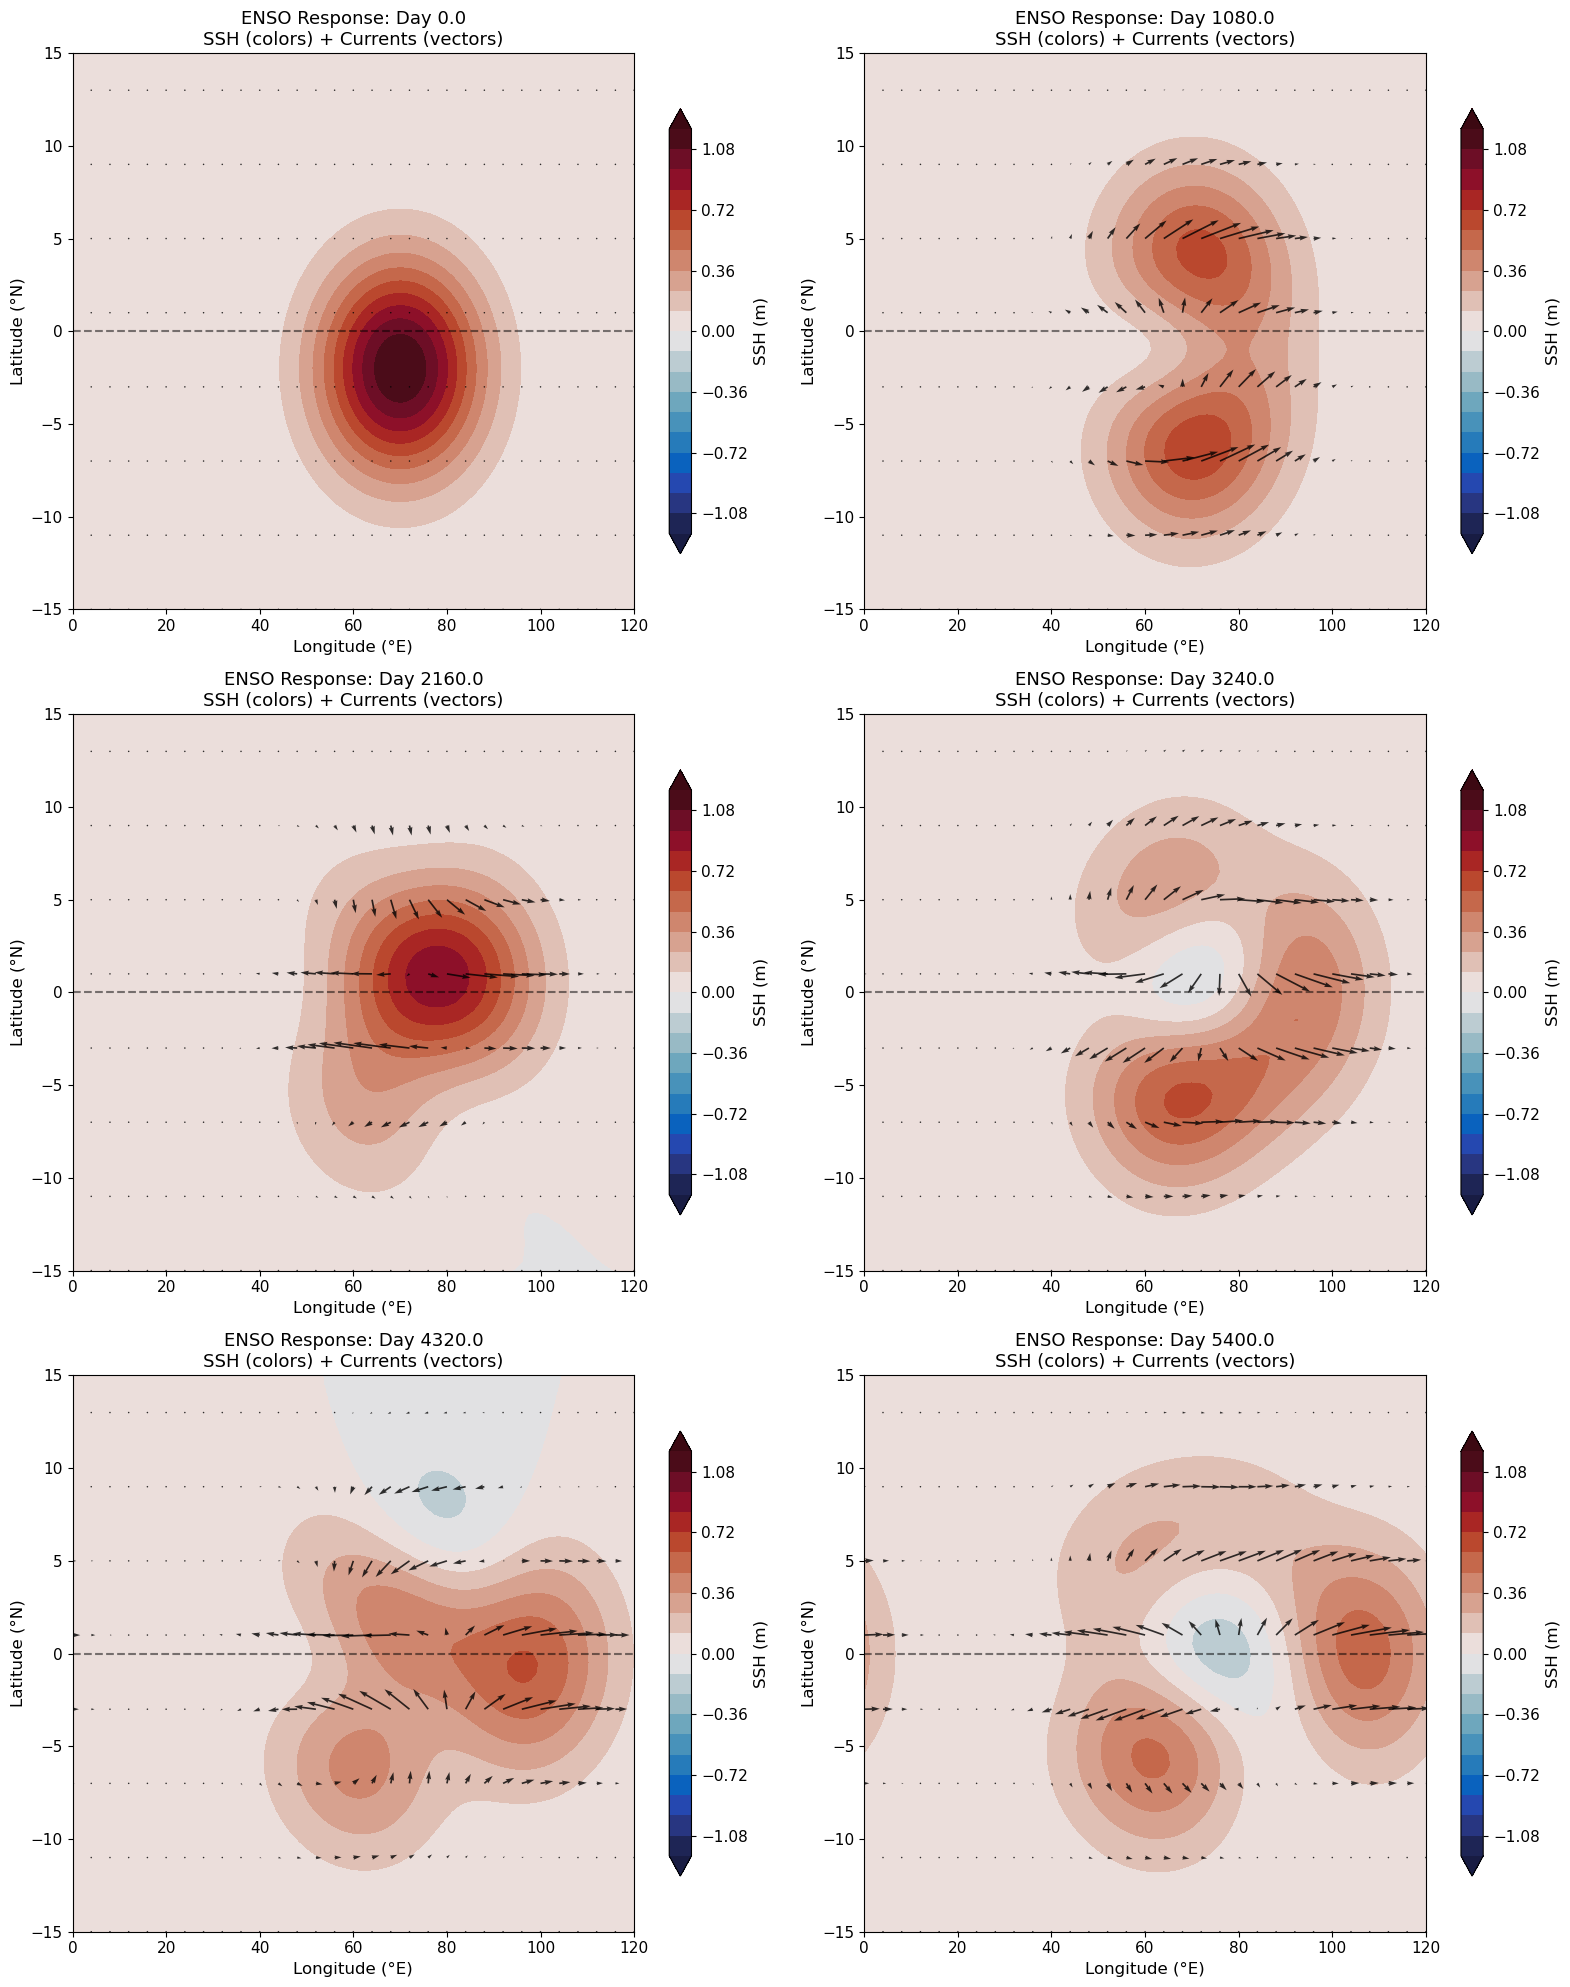

Initial forcing: Central Pacific wind stress anomaly
Kelvin response: Eastward SSH propagation (~5.0 m/s)
Rossby response: Westward adjustment (~0.33 m/s)
Time scales: Kelvin crossing ~31 days, Rossby ~467 days
Realistic ENSO: Wind → Kelvin (2-3 months) → Eastern warming → Rossby return (6-12 months)


In [17]:
# Create ENSO-like wind stress perturbation in central Pacific
ocean_enso = ocean_model.initialize_gaussian_perturbation(
    amplitude=1.2,          # 1.2 m SSH anomaly (strong El Niño scale)
    lon_center=70.0,        # Central 
    lat_center=-2.0,        # Slightly south of equator (realistic)
    sigma_lon=12.0,         # 12° longitude spread (regional wind stress)
    sigma_lat=4.0           # 4° latitude spread
)

print("Running ENSO wind stress response simulation...")
ocean_enso_states = ocean_model.integrate(ocean_enso)
ocean_enso_ds = ocean_model.to_xarray(ocean_enso_states)
print(f"✓ Simulation complete")

# ENSO evolution analysis
time_indices = [0, 180, 360, 540, 720, 900]  # 0, 1.875, 3.75, 5.625, 7.5, 9.375 days
fig, axes = plt.subplots(3, 2, figsize=(16, 20))
axes = axes.flatten()

time_days_enso = ocean_enso_ds.time * 24

for i, t_idx in enumerate(time_indices):
    if t_idx < len(ocean_enso_ds.time):
        time_val = time_days_enso[t_idx].values
        
        # Plot SSH field
        vmax = 1.2
        im = axes[i].contourf(ocean_enso_ds.lon, ocean_enso_ds.lat, 
                             ocean_enso_ds.eta[t_idx], 
                             levels=np.linspace(-vmax, vmax, 21), 
                             cmap=ocean_cmap, extend='both')
        
        # Add current vectors (subsampled for clarity)
        skip = 8
        current_scale = 15  # Slower ocean currents
        axes[i].quiver(ocean_enso_ds.lon[::skip], ocean_enso_ds.lat[::skip],
                      ocean_enso_ds.u[t_idx, ::skip, ::skip], 
                      ocean_enso_ds.v[t_idx, ::skip, ::skip],
                      scale=current_scale, alpha=0.8, width=0.003)
        
        axes[i].set_title(f'ENSO Response: Day {time_val:.1f}\nSSH (colors) + Currents (vectors)')
        axes[i].set_xlabel('Longitude (°E)')
        axes[i].set_ylabel('Latitude (°N)')
        axes[i].axhline(0, color='k', linestyle='--', alpha=0.5)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=axes[i], shrink=0.8)
        cbar.set_label('SSH (m)')

plt.tight_layout()
plt.show()

# Analysis of ENSO wave components
print(f"Initial forcing: Central Pacific wind stress anomaly")
print(f"Kelvin response: Eastward SSH propagation (~{ocean_model.c:.1f} m/s)")
print(f"Rossby response: Westward adjustment (~{ocean_model.c/15:.2f} m/s)")
print(f"Time scales: Kelvin crossing ~{120*111/(ocean_model.c*86.4):.0f} days, Rossby ~{120*111/(ocean_model.c/15*86.4):.0f} days")
print(f"Realistic ENSO: Wind → Kelvin (2-3 months) → Eastern warming → Rossby return (6-12 months)")

## 5. Oceanic Parameter Sensitivity Analysis

Examine how different equivalent depths (representing different baroclinic modes) affect
oceanic wave characteristics and ENSO-relevant time scales.

3rd mode     0.2      1.40       247          110                 
2nd mode     0.4      1.98       294          78                  
1st mode     0.6      2.43       326          64                  
Mixed mode   0.8      2.80       350          55                  
Surface mode 1.0      3.13       370          49                  


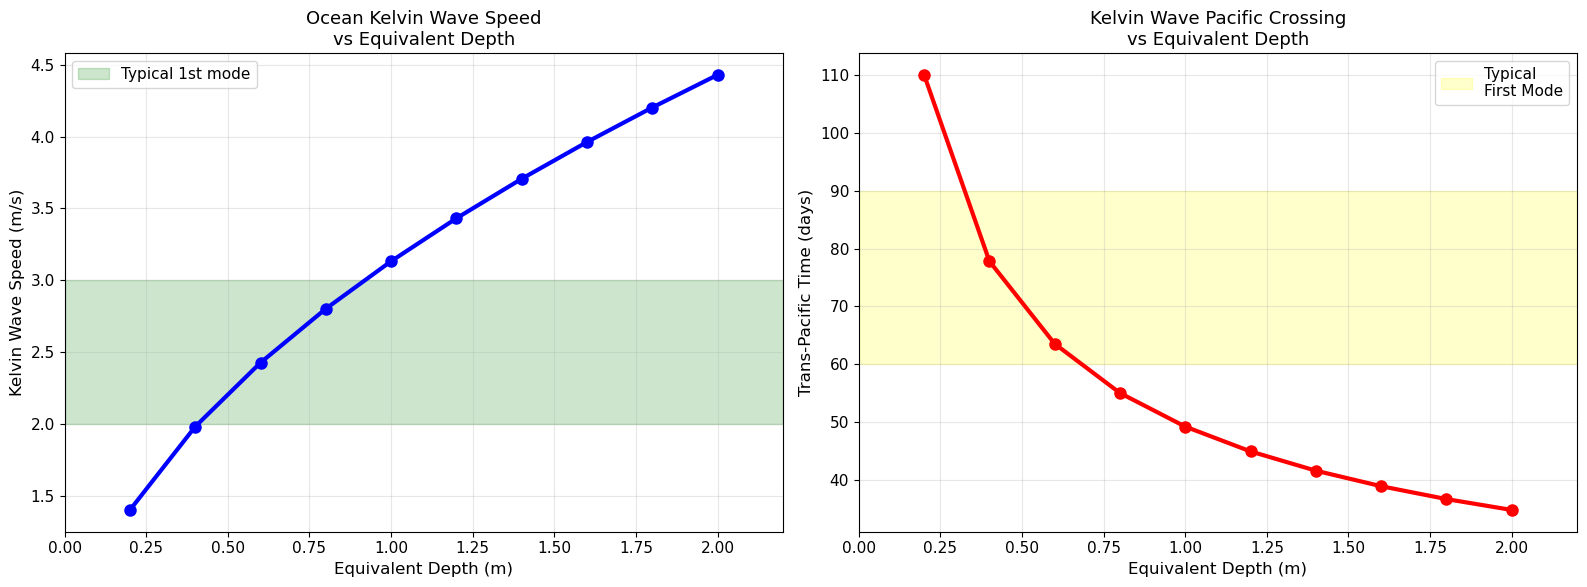


=== OCEANIC MODES ===
• 1st baroclinic (H=2.5m): thermocline variations
• 2nd baroclinic (H=1.5m): Higher-frequency oceanic variability
• 3rd+ modes (H<1m): Deep ocean adjustment, very slow time scales
• Mixed modes (H>4m): Surface-intensified, faster responses


In [32]:
# Test different oceanic equivalent depths (baroclinic modes)
ocean_depths = np.linspace(0.2,2.0,10)  # meters
mode_names = ['3rd mode', '2nd mode', '1st mode', 'Mixed mode', 'Surface mode']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Calculate parameters for each mode
ocean_wave_speeds = [np.sqrt(9.81 * h) for h in ocean_depths]
ocean_deformation_radii = [np.sqrt(c / (2 * 7.292e-5 / 6.371e6)) / 1000 for c in ocean_wave_speeds]
trans_pacific_days = [120 * 111 / (c * 86.4) for c in ocean_wave_speeds]  # 120° longitude crossing

for i, (h, mode, c, L, T) in enumerate(zip(ocean_depths, mode_names, ocean_wave_speeds, ocean_deformation_radii, trans_pacific_days)):
    print(f"{mode:<12} {h:<8.1f} {c:<10.2f} {L:<12.0f} {T:<20.0f}")

# Wave speed vs equivalent depth (oceanic range)
axes[0].plot(ocean_depths, ocean_wave_speeds, 'o-', linewidth=3, markersize=8, color='blue')
axes[0].set_xlabel('Equivalent Depth (m)')
axes[0].set_ylabel('Kelvin Wave Speed (m/s)')
axes[0].set_title('Ocean Kelvin Wave Speed\nvs Equivalent Depth')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, ocean_depths[-1]+0.2)

# Add observed ranges
axes[0].axhspan(2, 3, alpha=0.2, color='green', label='Typical 1st mode')
axes[0].legend()

# Trans-Pacific crossing time
axes[1].plot(ocean_depths, trans_pacific_days, 'o-', linewidth=3, markersize=8, color='red')
axes[1].set_xlabel('Equivalent Depth (m)')
axes[1].set_ylabel('Trans-Pacific Time (days)')
axes[1].set_title('Kelvin Wave Pacific Crossing\nvs Equivalent Depth')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, ocean_depths[-1]+0.2)

# Add observed ENSO time scales
axes[1].axhspan(60, 90, alpha=0.2, color='yellow', label='Typical\nFirst Mode')
axes[1].legend()

# # Stability analysis for oceanic time steps
# dt_minutes_ocean = np.linspace(5, 60, 50)
# for i, (h, mode, color) in enumerate(zip(ocean_depths, mode_names, colors)):
#     c = np.sqrt(9.81 * h)
#     dx = 120 * np.pi/180 * 6.371e6 / 240  # Grid spacing
#     cfl_numbers = c * (dt_minutes_ocean * 60) / dx
#     axes[1,1].plot(dt_minutes_ocean, cfl_numbers, linewidth=3, color=color, label=f'{mode} (H={h:.1f}m)')

# axes[1,1].axhline(1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='CFL = 1.0')
# axes[1,1].axhline(0.5, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='CFL = 0.5')
# axes[1,1].axhline(0.2, color='green', linestyle='--', linewidth=2, alpha=0.7, label='CFL = 0.2')
# axes[1,1].set_xlabel('Time Step (minutes)')
# axes[1,1].set_ylabel('CFL Number')
# axes[1,1].set_title('Oceanic Stability Analysis\nCFL vs Time Step')
# axes[1,1].legend(fontsize=9)
# axes[1,1].grid(True, alpha=0.3)
# axes[1,1].set_xlim(5, 60)
# axes[1,1].set_ylim(0, 1.5)

plt.tight_layout()
plt.show()

print(f"\n=== OCEANIC MODES ===")
print(f"• 1st baroclinic (H=2.5m): thermocline variations")
print(f"• 2nd baroclinic (H=1.5m): Higher-frequency oceanic variability")
print(f"• 3rd+ modes (H<1m): Deep ocean adjustment, very slow time scales")
print(f"• Mixed modes (H>4m): Surface-intensified, faster responses")